<a href="https://colab.research.google.com/github/rliu7926/weinstein-ligo-research/blob/main/4.1%20Updated%20Expectation%20SNR%20Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'
! pip install astropy

from astropy.cosmology import FlatLambdaCDM, Planck18, z_at_value
import numpy as np
import pylab
import math

import astropy.units as u
import matplotlib.pyplot as plt

from pycbc import waveform
from pycbc.waveform import get_td_waveform, get_fd_waveform

import pycbc
import pycbc.noise
import pycbc.psd

from random import randint
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pandas as pd
from pycbc.types import TimeSeries

import seaborn as sns
import time

     |████████████████████████████████| 3.1 MB 10.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 28.5 MB 59 kB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 52 kB 836 kB/s 
     |████████████████████████████████| 1.0 MB 41.4 MB/s 
     |████████████████████████████████| 1.6 MB 38.9 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 3.2 MB 34.6 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


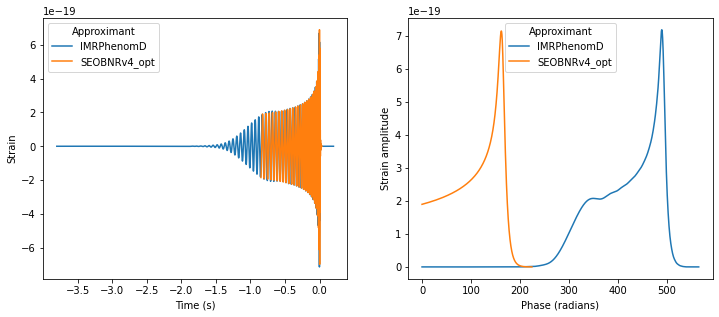

In [ ]:
## Compare different waveform approximants 

from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_td_waveform

fig = plt.figure(figsize=(12, 4.8))

for apx in ['IMRPhenomD', 'SEOBNRv4_opt']:
    hp, hc = get_td_waveform(approximant=apx, mass1=30, mass2=30, delta_t=1.0/4096, f_lower=20)
    hp, hc = hp.trim_zeros(), hc.trim_zeros()
    amp = waveform.utils.amplitude_from_polarizations(hp, hc)
    phase = waveform.utils.phase_from_polarizations(hp, hc)
  
    plt.subplot(1,2,1)
    plt.plot(hp.sample_times, hp)
    plt.xlabel("Time (s)")
    plt.ylabel("Strain")
    plt.legend(labels=['IMRPhenomD', 'SEOBNRv4_opt'], title="Approximant")

    plt.subplot(1,2,2)
    plt.plot(phase, amp)
    plt.xlabel("Phase (radians)")
    plt.ylabel("Strain amplitude")
    plt.legend(labels=['IMRPhenomD', 'SEOBNRv4_opt'], title="Approximant")

fig.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


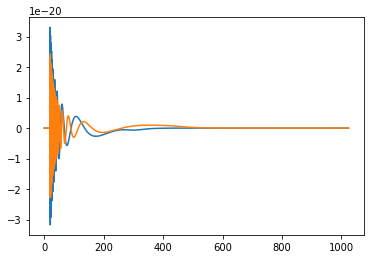

In [ ]:
## Figure out differences between get_td_waveform and get_fd_waveform

hplus30, hcross30 = get_fd_waveform(mass1=30, mass2=30, approximant="IMRPhenomD", f_lower=20, delta_f=1.0/16)
hplus20, hcross20 = get_fd_waveform(mass1=20, mass2=20, approximant="IMRPhenomD", f_lower=20, delta_f=1.0/16)

pylab.plot(hplus30.sample_frequencies, hplus30)
pylab.plot(hplus20.sample_frequencies, hplus20)


In [ ]:
## Create waveform function (taken from Section 3.1)

def create_waveform(mass1=30, mass2=30, spin1=[0, 0, 0], spin2=[0, 0, 0], resolution=1.0/1024, frequencybound=20, distance=500, cosmology=Planck18, approximant="IMRPhenomD"):

  redshift = 1 + z_at_value(cosmology.comoving_distance, distance * u.Mpc)
  
  fbound = frequencybound * redshift

  waveform, waveform_cross = get_td_waveform(approximant=approximant,
                                             mass1=mass1, mass2=mass2,
                                             spin1x=spin1[0], spin1y=spin1[1], spin1z=spin1[2],
                                             spin2x=spin2[0], spin2y=spin2[1], spin2z=spin2[2],
                                             delta_t=resolution/redshift,
                                             f_lower=fbound)
  
  waveform_amplitude = [0.0] * len(waveform)
  waveform_time = [0.0] * len(waveform)

  for i in range(len(waveform)):
    waveform_amplitude[i] = waveform[i]
    waveform_time[i] = waveform.sample_times[i]

  waveform_amplitude = [i/distance for i in waveform_amplitude]
  waveform_time = [i*redshift for i in waveform_time]

  waveform_amplitude = np.array(waveform_amplitude)
  waveform_time = np.array(waveform_time)

  return waveform_amplitude, waveform_time

In [ ]:
## Create frequency series waveform function (for expectation value function)

def create_fd_waveform(mass1, mass2, spin1, spin2, fres, flow, dist, cosmology=Planck18, approximant="IMRPhenomD"):

  redshift = 1 + z_at_value(cosmology.comoving_distance, dist * u.Mpc)

  flow_bound = flow * redshift

  hplus, hcross = get_fd_waveform(approximant=approximant,
                                  mass1=mass1, mass2=mass2,
                                  spin1x=spin1[0], spin1y=spin1[1], spin1z=spin1[2],
                                  spin2x=spin2[0], spin2y=spin2[1], spin2z=spin2[2],
                                  delta_f=fres * redshift,
                                  f_lower=flow_bound)
  
  freq_value = hplus.sample_frequencies / redshift
  freq_amp = hplus / dist * redshift

  return freq_amp, freq_value
  


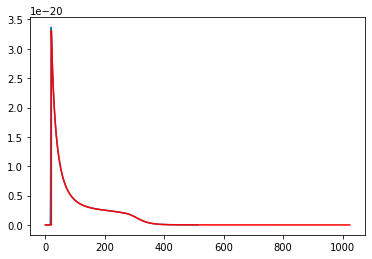

In [ ]:
distances = [1, 10, 100, 1000, 10000]

freq_amp, freq_value, time_amp, time_time, time_timetime, time_freq = ([0] * len(distances) for i in range(6))

for i in range(len(distances)):
  freq_amp[i], freq_value[i] = create_fd_waveform(30, 30, [0,0,0], [0,0,0], 1.0/16, 20, distances[i])
  time_amp[i], time_time[i] = create_waveform(30, 30, [0,0,0], [0,0,0], 1.0/1024, 20, distances[i])
  time_freq[i] = TimeSeries(time_amp[i], delta_t=1.0/1024)
  time_freq[i] = time_freq[i].to_frequencyseries(delta_f=1.0/16)

pylab.plot(time_freq[0].sample_frequencies, abs(time_freq[0]))
pylab.plot(freq_value[0], abs(freq_amp[0]), color="red")

In [ ]:
## Expectation value function (taken from 3.2)

def expectation_SNR_old(mass1, mass2, spin1, spin2, templatemass1, templatemass2, templatespin1, templatespin2, resolution, psdresolution, lowfreq, distance, templatedistance, psd, cosmology=Planck18, approximant="IMRPhenomD"):

  ## Create waveform 

  gwamp, gwtime = create_waveform(mass1=mass1, mass2=mass2, spin1=spin1, spin2=spin2, resolution=resolution, frequencybound=lowfreq, distance=distance, cosmology=cosmology, approximant=approximant)
  gwsignal = TimeSeries(gwamp, delta_t=resolution)
  gwsignalfreq = gwsignal.to_frequencyseries(delta_f = psdresolution)


  ## Create PSD 

  flen = int((1 / resolution) / (2 * psdresolution)) + 1

  if psd == 'aLIGOAPlusDesignSensitivityT1800042':
    psdfreq = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, psdresolution, lowfreq)
  
  if psd == 'aLIGODesignSensitivityP1200087':
    psdfreq = pycbc.psd.aLIGODesignSensitivityP1200087(flen, psdresolution, lowfreq)

  if psd == 'CosmicExplorerP1600143':
    psdfreq = pycbc.psd.CosmicExplorerP1600143(flen, psdresolution, lowfreq)


  ## Create template

  templateamp, templatetime = create_waveform(mass1=templatemass1, mass2=templatemass2, spin1=templatespin1, spin2=templatespin2, resolution=resolution, frequencybound=lowfreq, distance=templatedistance, cosmology=cosmology, approximant=approximant)
  templatesignal = TimeSeries(templateamp, delta_t=resolution)
  templatesignalfreq = templatesignal.to_frequencyseries(delta_f = psdresolution)


  ## Calculate SNR

  gwdata = gwsignalfreq + psdfreq
  snr = matched_filter(template=templatesignalfreq, data=gwdata, psd=psdfreq, low_frequency_cutoff=lowfreq)

  print("The signal-to-noise ratio is: {}".format(max(abs(snr))))

  return(max(abs(snr)))
  

In [ ]:
## New expectation value function using create_fd_waveform()

def expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, dist, tdist, psd, cosmology=Planck18, approximant="IMRPhenomD"):

  ## Create waveform and template

  gw_amp, gw_value = create_fd_waveform(mass1=mass1, mass2=mass2, spin1=spin1, spin2=spin2, fres=fres, flow=flow, dist=dist)
  signal_amp, signal_value = create_fd_waveform(mass1=tmass1, mass2=tmass2, spin1=tspin1, spin2=tspin2, fres=fres, flow=flow, dist=tdist)

  gwfreq = pycbc.types.frequencyseries.FrequencySeries(initial_array=gw_amp, delta_f=fres)
  signalfreq = pycbc.types.frequencyseries.FrequencySeries(initial_array=signal_amp, delta_f=fres)

  ## Create PSD 

  flen = len(gw_value)

  if psd == 'aLIGOAPlusDesignSensitivityT1800042':
    psdfreq = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, fres, flow)
  
  if psd == 'aLIGODesignSensitivityP1200087':
    psdfreq = pycbc.psd.aLIGODesignSensitivityP1200087(flen, fres, flow)

  if psd == 'CosmicExplorerP1600143':
    psdfreq = pycbc.psd.CosmicExplorerP1600143(flen, fres, flow)
    

  ## Calculate SNR

  gwdata = gwfreq + psdfreq
  snr = matched_filter(template=signalfreq, data=gwdata, psd=psdfreq, low_frequency_cutoff=flow)

  print("The signal-to-noise ratio is: {}".format(max(abs(snr))))

  return(max(abs(snr)))
  

In [ ]:
## Compare time and frequency domain analysis 

distances = np.arange(100, 10000, 100)

snr30, snr30old, snr50, snr50old, snr100, snr100old = ([0] * len(distances) for i in range(6))
snr = [snr30, snr50, snr100]
snrold = [snr30old, snr50old, snr100old]
mass = [30, 50, 100]

for i in range(len(snr30)):
  for s in range(len(snr)):
      snr[s][i] = expectation_SNR(mass1=mass[s], mass2=mass[s], tmass1=mass[s], tmass2=mass[s], 
                                 spin1=[0, 0, 0], spin2=[0, 0, 0], tspin1=[0, 0, 0], tspin2=[0, 0, 0],
                                 res=1.0/1024, fres=1.0/16, flow=20, 
                                 dist=distances[i], tdist=distances[i], 
                                 psd='aLIGODesignSensitivityP1200087', approximant='IMRPhenomD')
      
  for t in range(len(snrold)):
    snrold[t][i] = expectation_SNR_old(mass1=mass[t], mass2=mass[t], templatemass1=mass[t], templatemass2=mass[t],
                                   spin1=[0, 0, 0], spin2=[0, 0, 0], templatespin1=[0, 0, 0], templatespin2=[0, 0, 0],
                                   resolution=1.0/1024, psdresolution=1.0/16, lowfreq=20,  
                                   distance=distances[i], templatedistance=distances[i], 
                                   psd='aLIGODesignSensitivityP1200087', approximant='IMRPhenomD')
    print(snrold[t][i] / snr[t][i])

The signal-to-noise ratio is: 368.25697577476893
The signal-to-noise ratio is: 547.5667029442095
The signal-to-noise ratio is: 942.764846527325
The signal-to-noise ratio is: 368.25678198525054
0.9999994737655193
The signal-to-noise ratio is: 547.5643381159806
0.9999956812052008
The signal-to-noise ratio is: 942.7427433859181
0.9999765549792312
The signal-to-noise ratio is: 183.15021898169715
The signal-to-noise ratio is: 272.5464403960106
The signal-to-noise ratio is: 468.37806624177665
The signal-to-noise ratio is: 183.15012728519557
0.9999994993371993
The signal-to-noise ratio is: 272.5452654477459
0.9999956889979448
The signal-to-noise ratio is: 468.36705404452977
0.9999764886572609
The signal-to-noise ratio is: 121.4616357691657
The signal-to-noise ratio is: 180.89068206450477
The signal-to-noise ratio is: 310.21425475874935
The signal-to-noise ratio is: 121.461564325924
0.9999994118040545
The signal-to-noise ratio is: 180.8899025556265
0.9999956907184528
The signal-to-noise ratio 

In [ ]:
fig = plt.figure(figsize=(12, 4.8))

plt.subplot(1, 2, 1)
for i in range(len(snr)):
  plt.loglog(distances, snr[i])

plt.ylabel("Signal-to-Noise Ratio")
plt.ylim(0.1)
plt.xlabel("Distance (Mpc)")
plt.legend(labels=mass, title="Mass ($M_\odot$)")
plt.title("Frequency Domain Analysis")
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(len(snrold)):
  plt.loglog(distances, snrold[i])

plt.ylabel("Signal-to-Noise Ratio")
plt.ylim(0.1)
plt.xlabel("Distance (Mpc)")
plt.legend(labels=mass, title="Mass ($M_\odot$)")
plt.title("Time Domain Analysis")
plt.grid(True)

fig.tight_layout()
plt.show()

In [ ]:
## Compare frequency and time domain analysis runtimes 

start1 = time.time()

for i in range(100):
  x = expectation_SNR(30, 30, [0,0,0], [0,0,0], 30, 30, [0,0,0], [0,0,0], 1.0/2048, 1.0/16, 20, 2000, 2000, 'aLIGODesignSensitivityP1200087')

end1 = time.time()

print(f"Runtime of frequency domain analysis: {end1 - start1}")
# 11.396 seconds

start2 = time.time()

for i in range(100):
  x = expectation_SNR_old(30, 30, [0,0,0], [0,0,0], 30, 30, [0,0,0], [0,0,0], 1.0/2048, 1.0/16, 20, 2000, 2000, 'aLIGODesignSensitivityP1200087')

end2 = time.time()

print(f"Runtime of time domain analysis: {end2-start2}")
# 468.39 seconds (40x slower than fd analysis!)